<font size="5">Build Your Own ANUGA Model (BYOAM) </font>

<font size="3">In this notebook, we will:

- generate an unstructure mesh

- set initial conditions and boundary tags

    
- prepare configuration files for running the model




</font>

<font size="3">Before you can run this notebook, you should have run the 3_Set_Boundaries</font>


<font size=5> Step #1: Mount Google Drive and Grant Access <font> <br>




<font size=3> When you run the next cell, a pop-up window will appear asking you to grant access to your Google Drive. You must approve or the notebook will not work. <font> <br>


In [1]:
import sys
import os
path = os.getcwd() + '/'
where_to_mount = '/content/drive/'

from google.colab import drive
drive.mount(where_to_mount, force_remount=True)

mounted_drive = where_to_mount + 'MyDrive/'

Mounted at /content/drive/


<font size=5> Step #2: Install packages. <font> <br>
<font size=3> This cell should install all Python packages you need for each tutorial.<font>

In [2]:
import os
os.chdir(mounted_drive)
if os.path.isdir(mounted_drive + 'komo_estuary_tutorial'):
  print('## Updating the local git repository \n')
  os.chdir(mounted_drive + '/komo_estuary_tutorial')
  ! git pull 
else:
  print('## Pulling the git repository with files for the tutorial\n')
  ! git clone https://github.com/achri19/komo_estuary_tutorial.git

print('\n## Installing the Python packages needed for these tutorials\n')
!/bin/bash $mounted_drive/komo_estuary_tutorial/install_packages.sh


## Updating the local git repository 

Already up to date.

## Installing the Python packages needed for these tutorials

/content/drive/MyDrive//komo_estuary_tutorial/install_packages.sh: line 4: cd: /content/drive/MyDrive/installations: No such file or directory
(1) Install pip packages
nose mpi4py triangle Pmw pymetis cmocean geopandas fiona pygeos rasterio rasterstats
(2) Install gdal
(3) Install netcdf4
(4) Download anuga_core github repository
https://github.com/GeoscienceAustralia/anuga_core
(5) Install anuga
(7) Completed


<font size=5> Step #3: Set up working directories<font> 


<font size=3> We will access data files stored on a shared Google Drive. You will also need to save files to your own Google Drive.<font>



In [3]:
path = where_to_mount + 'MyDrive/processing/'
path_code = path + 'code/'
path_templates = path +  'templates/'
path_configs = path + 'configs/'
path_ancillary = path + 'ancillary/'
sys.path.insert(1,path_code)


<font size=5> Step #4: Now we will import Python packages, which will be used for future tutorials. If there are any errors, try rerunning the first cell <font> 




In [4]:
# Standard packages
import os
import time
import sys
import fnmatch
import numpy as np
import scipy
import scipy.interpolate
import pandas as pd
from datetime import datetime
from string import Template
import geopandas as gpd
from shapely.geometry import Polygon, Point
import rasterio
from pathlib import Path
from shapely.geometry import LineString

## ANUGA packages
import anuga
from anuga.utilities.plot_utils import Make_Geotif
from anuga.coordinate_transforms.geo_reference import Geo_reference
from anuga.utilities import animate
from anuga import myid, numprocs, finalize, barrier
from anuga.parallel.parallel_inlet_operator import Parallel_Inlet_operator

## Plotting modules
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

#mpl.rcParams['animation.ffmpeg_path'] = r'/Users/alchrist/Downloads/ffmpeg'
## If you get an error with producing animation plots, uncomment the line above and add directory for ffmpeg (r'/PATH/TO/ffmpeg')
import matplotlib.animation as animation
writer = animation.FFMpegWriter(fps=60)



In [5]:
from fix_polygons import getpolygonpoints, removenearbypoints, delete_holes
from BYOM_Utilities_V1 import (build_directory,
                               get_extent_parameters,
                               setup_AOI_files, 
                               make_polygons,
                               make_channel_networks,
                               make_model_foundation, 
                               set_boundary_conditions, 
                               make_watermask,
                               more_opening)
from BYOM_extra import make_mesh_polygons, determine_riverscale



/content/drive/MyDrive/processing/code/use_orinoco.py:39: UserWarning: ShapelyDeprecationWarning
  warnings.warn('ShapelyDeprecationWarning')
/content/drive/MyDrive/processing/code/use_orinoco.py:40: UserWarning: UserWarning
  warnings.warn('UserWarning')


<font size= 5 color = 'red'> Copy the AOI and elevationpath from the previous notebook into the cell below:

In [6]:
AOI = 'komo'

Path((mounted_drive + AOI)).mkdir(parents=True, exist_ok=True)

skip = False
res = 30 #meters
print('\n')
print('Study area is ' + AOI)
print('Resolution of this setup is %sm' %(res))

working_path,folders = build_directory(mounted_drive, AOI)



Study area is komo
Resolution of this setup is 30m



##############################################################################################
################################[Step 1][Build Directory]#####################################
##############################################################################################

##################### The working directory set as: 

/content/drive/MyDrive/komo/
 
##################### Folders are:
##################### 0 User_Defined_Files --> User shapefile of model domain and water mask
##################### 1 tmp --> For temporary files
##################### 3 Meshes --> Where we will build model meshes
##################### 4 DEMs --> Where we will build digital elevation models
##################### 5 Boundaries --> Where we will store boundary files
##################### 6 Simulations --> Where we will run simulations
##################### 7 Setup_Files/Setup_SHP --> Shapefiles for setup 
##################### 8 Setup_F

<font size = 5> We will now build the mesh/domain for the model. This file will be saved and can be reused for multiple simulations.

<font size =5 color='red'> Get Parameters </font>

In [7]:
parameters = pd.read_csv('%s/%s_Configuration.csv' %(folders[2],AOI))
EPSG            = int(parameters['EPSG'][0])                         # Coordinate system

In [8]:
ref = rasterio.open('%s%s_GEBCO_%s.tif' %(folders[8],AOI,res))
ref_profile = ref.profile


<font size=5 color='red'> Get median river width to determine scale of mesh in river polygons </font>

In [9]:
segment_width = 150
pixel_step = int(round(segment_width/res))

if os.path.isfile("%s%s_widths_%sx%s.tif" %(folders[8],AOI,res,pixel_step))==False:
    distance,widths = make_channel_networks(folders,
                                            AOI,
                                            ref,
                                            parameters,
                                            pixel_step,
                                            os.path.isfile("%s%s_widths_%sx%s.tif" %(folders[8],AOI,res,pixel_step)))
med_width, riverscale, cellsperwidth = determine_riverscale(folders,
                                                              AOI,
                                                              ref,
                                                              parameters,
                                                              pixel_step,
                                                              False)




##############################################################################################
######################################## [River Scale] #######################################
##############################################################################################


[Get Riverscale][Get Median Width of Rivers] .......

##################### Median river width is 1170.0m

[Get Riverscale][How many cells per width] .......

##################### Cells per river width is 5

[Get Riverscale][Estimate maximum triangle size to maintain 5 per median 1170.0m river width] .......

##################### Therefore, max triangle scale is 27378m2


<font size= 5 color = 'red'> Get Mesh Parameters

<font size= 5 color = 'red'> For this tutorial, we will be using a uniform mesh. If you want to refine the mesh, you must create polygons that outline areas of refinement. We won't go over that today. </font>



In [10]:
uniform = True 
base_triangle = 10000
base_length  = int((base_triangle*2)**0.5)
print('\nBase maximum triangle size is \n%sm2 ' %(base_triangle))



Base maximum triangle size is 
10000m2 


In [11]:
mesh_names = ['base']
mesh_triangles = [10000]
print('Mesh is uniform, with maximum triangle area of %s' %(mesh_triangles))
    
mesh_shapefiles =[]
for mesh in range(len(mesh_names)):
    mesh_shapefiles = np.concatenate((mesh_shapefiles,[os.path.join(dirpath,f)
            for dirpath,dirnames, files in os.walk(folders[3])
            for f in fnmatch.filter(files,'%s*%s_mesh_%s.shp' %(AOI,mesh_names[mesh],res))]),axis=0)


Mesh is uniform, with maximum triangle area of [10000]


In [12]:
mesh_file = 'Meshes'
for mesh in range(len(mesh_names)):
    mesh_file = mesh_file +'_' + mesh_names[mesh] + '_' + str(mesh_triangles[mesh]) + 'm2'
print(mesh_file)

Meshes_base_10000m2


In [13]:
mesh_path = folders[3] + mesh_file + '/' 
Path('%s' %(mesh_path)).mkdir(parents=True, exist_ok=True)
Path('%s' %(folders[1])).mkdir(parents=True, exist_ok=True)

print('Folder for mesh files is %s' %(mesh_path))

Folder for mesh files is /content/drive/MyDrive/komo/Meshes/Meshes_base_10000m2/


In [14]:
print('Model domain is rectangular, clear North, South, West, and East Boundaries')
extentpoly = gpd.read_file("%s%s_extent_%s.shp" %(folders[7],AOI,EPSG))
ulx,lry,lrx,uly = extentpoly.total_bounds   # Coordiates converted to UTM coordinate system
temp, domain   = getpolygonpoints(extentpoly,ulx,uly,lrx,lry,base_length)
perimeter = temp.length
extent = tuple((point.coords[0][0],point.coords[0][1]) for point in (domain.geometry[:]))
extent2 = []
for feat in domain.geometry:
    extent2.append([round(feat.x,5), round(feat.y,5)])
extent2 = np.array(extent2)
north = np.where((extent2[:,1]==round(uly,5)))
south = np.where((extent2[:,1]==round(lry,5)))
west  = np.where((extent2[:,0]==round(ulx,5)))
east  = np.where((extent2[:,0]==round(lrx,5)))
other_tag = np.where((extent2[:,1]!=round(uly,5))&(extent2[:,1]!=round(lry,5))&(extent2[:,0]!=round(ulx,5))&(extent2[:,0]!=round(lrx,5)))
print('There are a total of %s boundary nodes' %(len(domain)))
print('There are %s boundary nodes tagged as North boundaries' %(len(north[0])))
print('There are %s boundary nodes tagged as South boundaries' %(len(south[0])))
print('There are %s boundary nodes tagged as West boundaries' %(len(west[0])))
print('There are %s boundary nodes tagged as East boundaries' %(len(east[0])))
print('There are %s boundary nodes tagged as Other boundaries' %(len(other_tag[0])))
  
np.savetxt('%s%s_domain_points.csv' %(mesh_path,AOI), extent,delimiter=',', fmt= '%1.9f') ## USED BY ANUGA MODEL



Model domain is rectangular, clear North, South, West, and East Boundaries
There are a total of 2486 boundary nodes
There are 769 boundary nodes tagged as North boundaries
There are 768 boundary nodes tagged as South boundaries
There are 475 boundary nodes tagged as West boundaries
There are 475 boundary nodes tagged as East boundaries
There are 0 boundary nodes tagged as Other boundaries


In [15]:
domain['index'] = domain.index.astype('int')
domain['tag'] = ''

domain['tag'][domain['index'].isin(north[0])] = 'north'
domain['tag'][domain['index'].isin(south[0])] = 'south'
domain['tag'][domain['index'].isin(west[0])] = 'west'
domain['tag'][domain['index'].isin(east[0])] = 'east'
domain['tag'][domain['index'].isin(other_tag[0])] = 'other'

domain.to_file('%s%s_domain_points.shp' %(mesh_path,AOI))

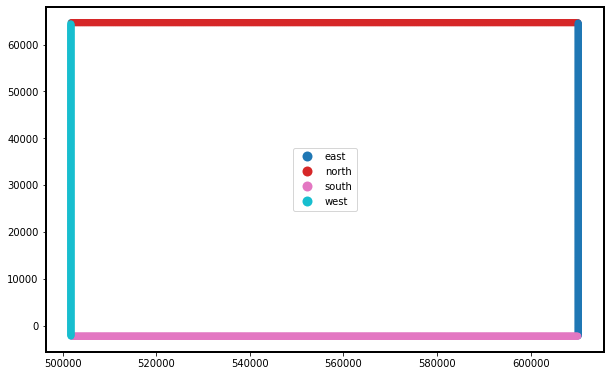

In [16]:
fig, ax = plt.subplots(figsize = (10,10))
#boundary_segments.plot(ax=ax,column='boundary',categorical=True,legend=True,color='k')
domain.plot(ax=ax,column='tag',categorical=True,legend=True)
plt.savefig('%s/boundarytags.png' %(mesh_path))


In [17]:
bounding_polygon = anuga.read_polygon('%s%s_domain_points.csv' %(mesh_path,AOI))
A = anuga.polygon_area(bounding_polygon) / 1000000.0
print('################################# Bounding Polygon defined by :               %s_domain_points.csv' %(AOI))
print('################################# Area of bounding polygon:                   %.2f km^2' %(A))
print('################################# Base triangle area for unrefined areas:     %s km^2' %(base_length/1000000.00))



################################# Bounding Polygon defined by :               komo_domain_points.csv
################################# Area of bounding polygon:                   7255.78 km^2
################################# Base triangle area for unrefined areas:     0.000141 km^2


In [18]:
minlength = (min(mesh_triangles)*2)**0.5
maxlength = (max(mesh_triangles)*2)**0.5

interior_regions = []
missing = gpd.GeoDataFrame(columns =['geometry'], crs = EPSG)


<font size = 5 color='red'> We now use ANUGA utilities to biuld the model mesh (Triangle Software)

In [19]:
geo_reference = Geo_reference(zone=EPSG,
                                datum='wgs84',
                                projection='UTM',
                                false_easting=500000,
                                false_northing=0)

In [20]:

anuga.create_mesh_from_regions(
    bounding_polygon,
    boundary_tags={'North': north[0],
                    'East': east[0],
                    'South': south[0],
                    'West': west[0]},
    maximum_triangle_area = base_triangle,
    filename =  mesh_path + mesh_file + '.tsh',
    use_cache = False,
    verbose = False,
    poly_geo_reference=geo_reference,
    mesh_geo_reference=geo_reference,
    )
    



        mesh Triangles: [] 
        mesh Attribute Titles: [] 
        mesh Segments: []  
        mesh Vertices: [] 
        user Segments: [[[[(501794.000000,64701.000000),[]], [(501934.998699,64701.000000),[]]],West], [[[(501934.998699,64701.000000),[]], [(502075.997398,64701.000000),[]]],North], [[[(502075.997398,64701.000000),[]], [(502216.996096,64701.000000),[]]],North], [[[(502216.996096,64701.000000),[]], [(502357.994795,64701.000000),[]]],North], [[[(502357.994795,64701.000000),[]], [(502498.993494,64701.000000),[]]],North], [[[(502498.993494,64701.000000),[]], [(502639.992193,64701.000000),[]]],North], [[[(502639.992193,64701.000000),[]], [(502780.990892,64701.000000),[]]],North], [[[(502780.990892,64701.000000),[]], [(502921.989590,64701.000000),[]]],North], [[[(502921.989590,64701.000000),[]], [(503062.988289,64701.000000),[]]],North], [[[(503062.988289,64701.000000),[]], [(503203.986988,64701.000000),[]]],North], [[[(503203.986988,64701.000000),[]], [(503344.985687,64701

In [21]:
#! pip install backports.zoneinfo
mesh_domain = anuga.create_domain_from_file(mesh_path + mesh_file+'.tsh')


Figure files for each frame will be stored in /content/drive/MyDrive/komo/Meshes/Meshes_base_10000m2//plot/


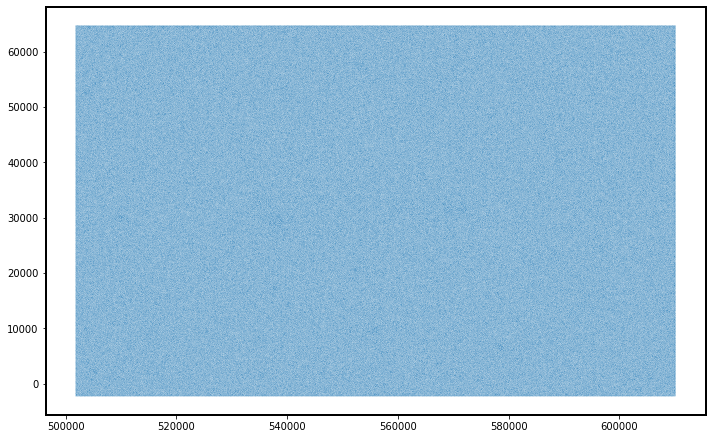

In [22]:
fig = plt.figure(figsize=(10,10))
dplotter = animate.Domain_plotter(mesh_domain,plot_dir = mesh_path + '/plot/')
plt.triplot(dplotter.triang,linewidth=0.1)
plt.axis('scaled')
plt.tight_layout()
plt.savefig('%s/plot/mesh%s.png' %(mesh_path,myid))


In [23]:

parameters.loc[0,'MeshName'] = mesh_file
parameters.to_csv(folders[6] + '/config_%s_%s.csv' %(AOI,datetime.now().strftime("%Y%m%d")))


<font size=5 color='red'> Done building the mesh. Move on to the next notebook 5_Run_ANUGA.ipynb </font>
